<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Regularization Exercise

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Run this before any other code cell
# This downloads the csv data files into the same directory where you have saved this notebook

import urllib.request
from pathlib import Path
import os
path = Path()

# Dictionary of file names and download links
files = {'Auto.csv':'https://storage.googleapis.com/aipi_datasets/Auto.csv'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

In [3]:
def load_data(filename):
    # Read in data
    data = pd.read_csv(filename)
    # Remove rows with missing values
    data = data[data['horsepower'] != '?'].copy()
    return data

data = load_data('Auto.csv')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


## LASSO Regression
Let's use LASSO Regression to add regularization and see what impact it has on the features included in the model.  First we will run a standard linear regression to get a baseline.

In [4]:
def prep_data_allfeats(data,pct):
    # Define the features and response (X and y)
    X = data[['cylinders','displacement','horsepower','weight','acceleration','year']].copy().astype(int)
    y = data['mpg'].copy().astype(float)

    # Split into training and test sets
    X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=pct)
    return X_train,X_test,y_train,y_test

# Split our data
X_train,X_test,y_train,y_test = prep_data_allfeats(data,pct=0.2)

Now let's try a LASSO model.  First we need to scale our data

MSE on the test set is 13.124
y = 23.482 + -0.000*cylinders + -0.000*displacement + -0.094*horsepower + -4.790*weight + 0.000*acceleration + 1.951*year


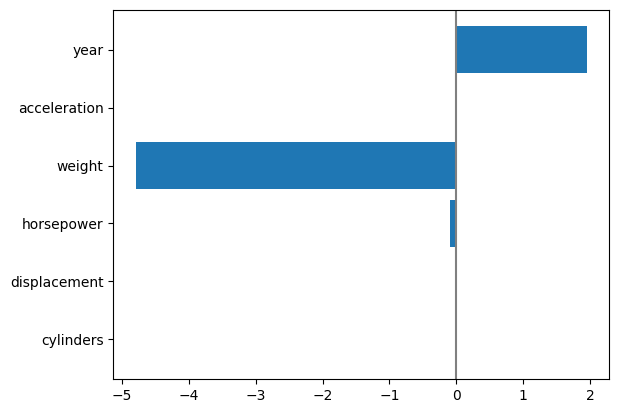

In [5]:
def train_lasso(X_train,y_train,alpha=1.):
    # First we scale our data - remember, only use the training data to fit the scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Run a LASSO model
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train_scaled,y_train)
    return scaler,lasso_model

def test_model(model, X_test, y_test,transform=None):
    # Compute the MSE for a model
    if transform is not None:
        X_test = transform.transform(X_test)
    preds = model.predict(X_test)
    mse = 1/len(y_test)*np.sum((preds-y_test)**2)
    return mse
    
scaler,model = train_lasso(X_train,y_train)
test_mse = test_model(model, X_test, y_test,transform=scaler)
print('MSE on the test set is {:.3f}'.format(test_mse))

# Display the equation for the LASSO model
coef = model.coef_
intercept = model.intercept_
equation = 'y = {:.3f} + '.format(intercept) + ' + '.join(['{:.3f}*{}'.format(coef,var) for coef,var in zip(coef,X_train.columns)])
print(equation)

# Plot the coefficients
plt.barh(X_train.columns,coef)
plt.axvline(x=0, color='.5')
plt.show()

As we can see above, our LASSO model at lambda/alpha=1.0 zeroed out several of our model coefficients, leaving only weight, horsepower, and year in our model.

Let's look for the optimal value of the lambda (alpha) hyperparameter.  Since the possible range of values for lambda is 0 to infinity, let's start with a big picture analysis and then zoom in

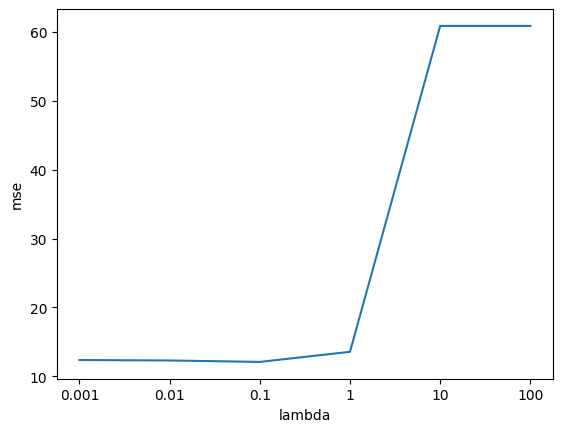

In [6]:
def optimize_regularization(X_train,y_train,model,alpha_vals,nsplits=10):
    '''
    Finds the optimal value of alpha/lambda from a given range using cross-validation

    Inputs:
        X_train(pd.DataFrame): training set inputs
        y_train(pd.Series): training set labels
        model(sklearn.base.BaseEstimator): instantiated scikit-learn model object
        alpha_vals(list): list of values to evaluate for alpha/lambda
        nsplits(int): number of folds for cross-validation

    Returns:
        opt_lambda(float): alpha/lambda value from the input list that results in best cross-validation performance
        errors(list): list of mean MSE across validation folds for each value of alpha/lambda
    '''

    ### BEGIN SOLUTION ####

    # First we scale our data - remember, only use the training data to fit the scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    kf = KFold(n_splits=nsplits)
    errors = []

    for val in alpha_vals:
        model.alpha = val
    
        # Run cross-validation
        mse_folds = []
        for (train_idx,val_idx) in kf.split(X=X_train_scaled,y=y_train):
            # Split training and validation sets for each fold
            X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Fit model to the training data for this iteration
            model.fit(X_fold_train,y_fold_train)

            # Get predictions for the validation fold and calculate mse
            val_preds = model.predict(X_fold_val)
            mse_val = 1/y_fold_val.shape[0]*np.sum((val_preds-y_fold_val)**2)
            mse_folds.append(mse_val)
            
        errors.append(np.mean(mse_folds))

    # Get the optimal lambda/alpha
    opt_lambda = alpha_vals[np.argmin(errors)]

    return opt_lambda, errors

    ### END SOLUTION ###


# Now let's vary the lambda (alpha) hyperparameter and find the optimal value using cross-validation
alpha_vals = [10**i for i in range(-3,3,1)]
model = Lasso()
opt_alpha, errors = optimize_regularization(X_train,y_train,model,alpha_vals,nsplits=10)
assert len(errors) == len(alpha_vals)
assert opt_alpha == 0.1
    
# Plot the mse vs lambda/alpha values, using log scale for lambda values
plt.plot(np.log(alpha_vals),errors)
plt.xticks(ticks=np.log(alpha_vals),labels=alpha_vals)
plt.xlabel('lambda')
plt.ylabel('mse')
plt.show()

Now let's zoom in to identify the optimal lambda value

Optimal lambda value is 0.050


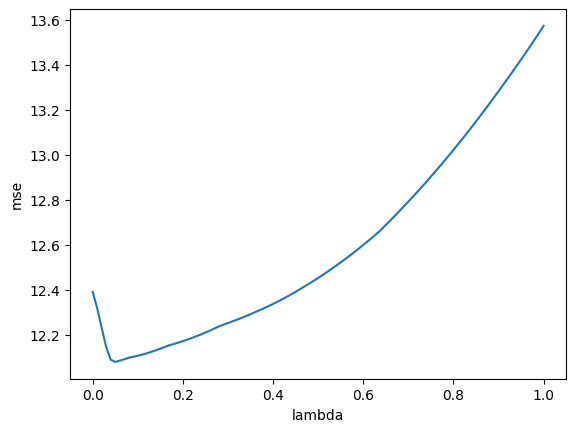

In [7]:
alpha_vals = np.arange(0.,1.01,0.01)
opt_alpha, errors = optimize_regularization(X_train,y_train,model,alpha_vals,nsplits=10)

print('Optimal lambda value is {:.3f}'.format(opt_alpha))
    
# Plot the mse vs lambda/alpha values
plt.plot(alpha_vals,errors)
plt.xlabel('lambda')
plt.ylabel('mse')
plt.show()

### Based on what we learned in the lecture, why might higher penalty values for the LASSO not work well in this particular case?

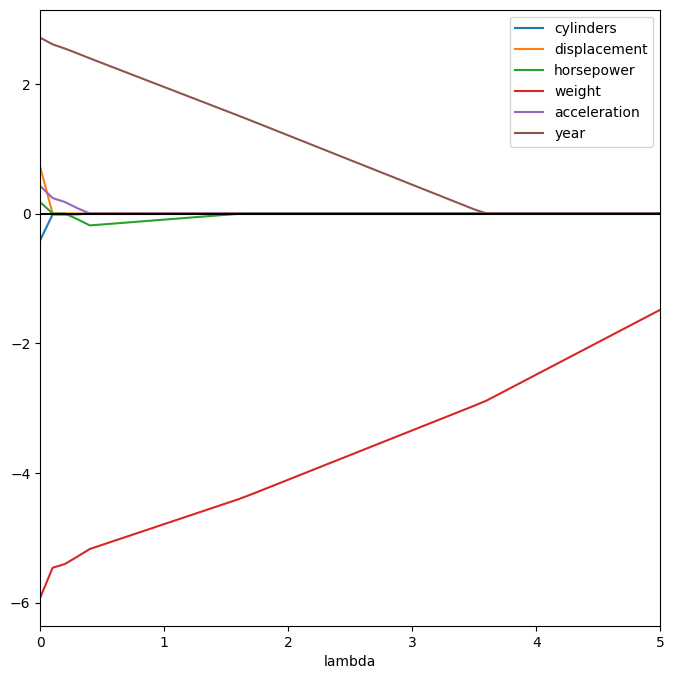

In [8]:
# Now let's vary the lambda (alpha) hyperparameter and visualize the change in coefficients
coeff_vals = {var:[] for var in X_train.columns} # Dict to hold values of each coefficient

alpha_vals = np.arange(0.,5.01,0.1)
for val in alpha_vals:
    scaler,lasso_model = train_lasso(X_train,y_train,alpha=val)
    coef = lasso_model.coef_
    for coef,var in zip(coef,X_train.columns):
        coeff_vals[var].append(coef)
        
# Plot the coefficient values
plt.figure(figsize=(8,8))
for var in coeff_vals.keys():
    plt.plot(alpha_vals,coeff_vals[var],label=var)
plt.plot([0,np.max(alpha_vals)],[0,0],color='black')
plt.xlim(0,np.max(alpha_vals))
plt.legend()
plt.xlabel('lambda')
plt.show()


MSE on the test set is 11.905
y = 23.482 + -0.013*cylinders + -0.000*displacement + -0.000*horsepower + -5.493*weight + 0.270*acceleration + 2.643*year


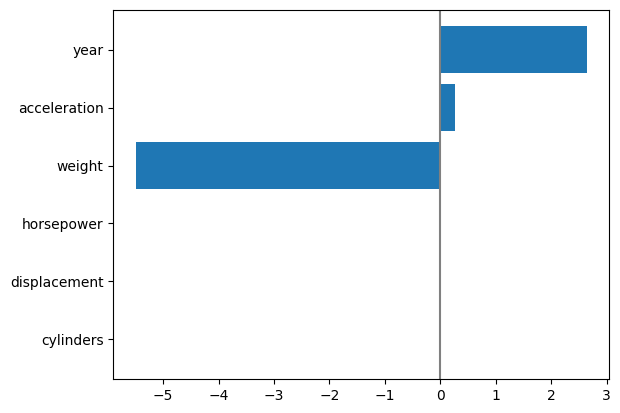

In [20]:
# Evaluate performance of the model with the optimized alpha/lambda
scaler,model = train_lasso(X_train,y_train,alpha=opt_alpha)
test_mse = test_model(model, X_test, y_test, transform=scaler)
print('MSE on the test set is {:.3f}'.format(test_mse))

# Display the equation for the LASSO model
coef = model.coef_
intercept = model.intercept_
equation = 'y = {:.3f} + '.format(intercept) + ' + '.join(['{:.3f}*{}'.format(coef,var) for coef,var in zip(coef,X_train.columns)])
print(equation)

# Plot the coefficients
plt.barh(X_train.columns,coef)
plt.axvline(x=0, color='.5')
plt.show()

## Ridge Regression

In [15]:
def train_ridge(X_train,y_train,alpha=1.0):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Run a Ridge model using the default lambda (alpha)
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_scaled,y_train)
    
    return scaler, ridge_model

scaler,model = train_ridge(X_train,y_train)
test_mse = test_model(model, X_test, y_test, transform=scaler)
print('MSE on the test set is {:.3f}'.format(test_mse))

MSE on the test set is 11.917


Of the values evaluated, the optimal lambda value is 1.000


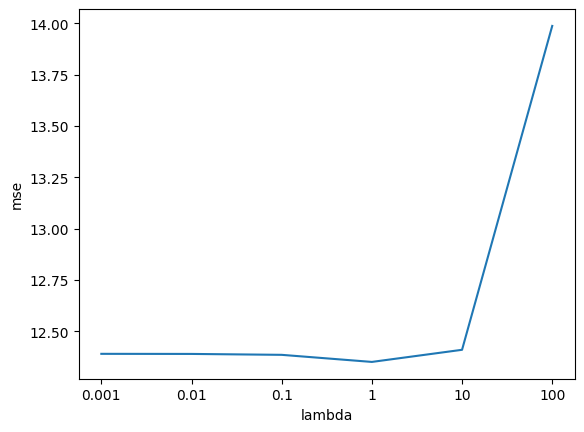

In [16]:
# Now let's vary the lambda (alpha) hyperparameter and find the optimal value using cross-validation
alpha_vals = [10**i for i in range(-3,3,1)]
model = Ridge()
opt_alpha_ridge, errors = optimize_regularization(X_train,y_train,model,alpha_vals,nsplits=10)
print('Of the values evaluated, the optimal lambda value is {:.3f}'.format(opt_alpha_ridge))
    
# Plot the mse vs lambda/alpha values
plt.plot(np.log(alpha_vals),errors)
plt.xticks(ticks=np.log(alpha_vals),labels=alpha_vals)
plt.xlabel('lambda')
plt.ylabel('mse')
plt.show()

Of the values evaluated, the optimal lambda value is 3.500


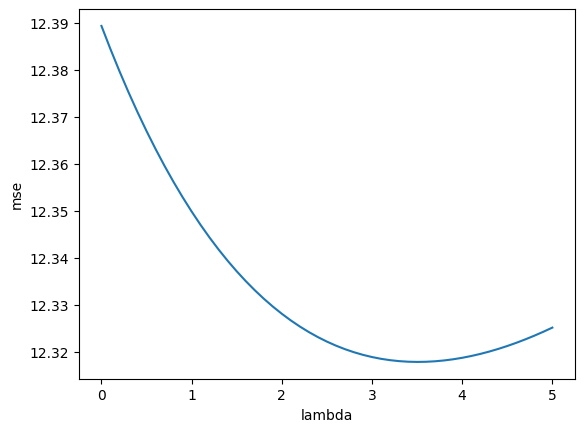

In [17]:
# Now let's vary the lambda (alpha) hyperparameter and find the optimal value using cross-validation
alpha_vals = np.arange(0.,5.01,0.1)
model = Ridge()
opt_alpha_ridge, errors = optimize_regularization(X_train,y_train,model,alpha_vals,nsplits=10)
print('Of the values evaluated, the optimal lambda value is {:.3f}'.format(opt_alpha_ridge))
    
# Plot the mse vs lambda/alpha values
plt.plot(alpha_vals,errors)
plt.xlabel('lambda')
plt.ylabel('mse')
plt.show()

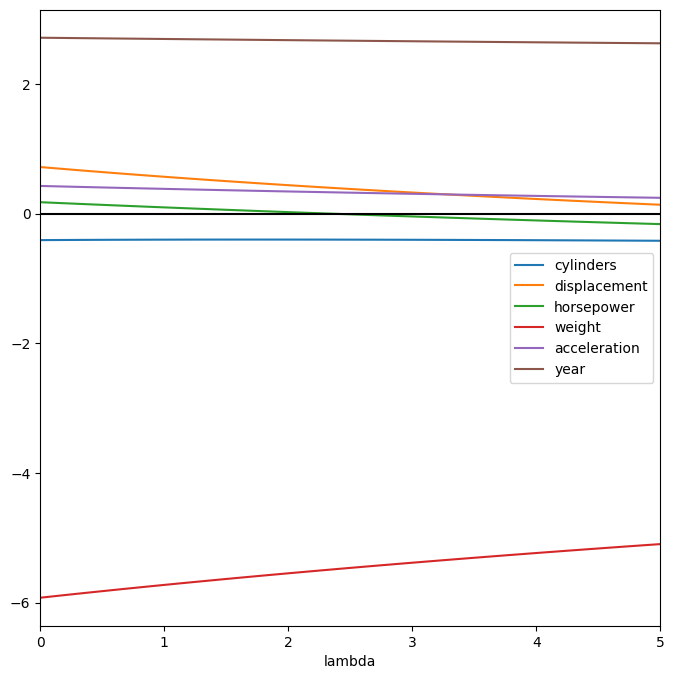

In [18]:
# Now let's vary the lambda (alpha) hyperparameter and visualize the change in coefficients
coeff_vals = {var:[] for var in X_train.columns} # Dict to hold values of each coefficient

alpha_vals = np.arange(0.,5.05,0.05)
for val in alpha_vals:
    scaler,model = train_ridge(X_train,y_train,val)
    # Get coefficients to plot
    coef = model.coef_
    for coef,var in zip(coef,X_train.columns):
        coeff_vals[var].append(coef)
        
# Plot the coefficient values
plt.figure(figsize=(8,8))
for var in coeff_vals.keys():
    plt.plot(alpha_vals,coeff_vals[var],label=var)
plt.plot([0,np.max(alpha_vals)],[0,0],color='black')
plt.xlim(0,np.max(alpha_vals))
plt.legend()
plt.xlabel('lambda')
plt.show()

MSE on the test set is 11.951
y = 23.482 + -0.410*cylinders + 0.709*displacement + 0.170*horsepower + -5.916*weight + 0.423*acceleration + 2.710*year


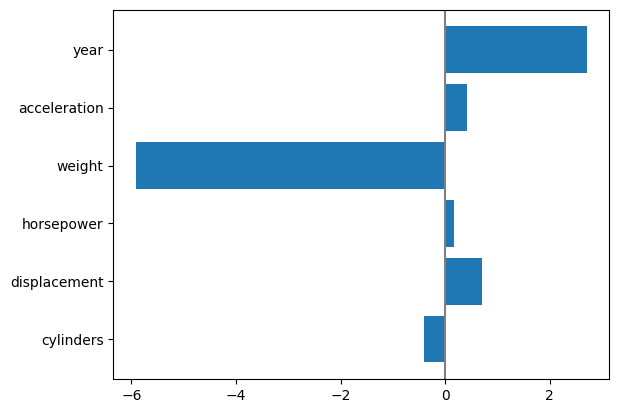

In [19]:
# Evaluate performance of the model with the optimized alpha/lambda
scaler,model = train_ridge(X_train,y_train,alpha=opt_alpha)
test_mse = test_model(model, X_test, y_test, transform=scaler)
print('MSE on the test set is {:.3f}'.format(test_mse))

# Display the equation for the LASSO model
coef = model.coef_
intercept = model.intercept_
equation = 'y = {:.3f} + '.format(intercept) + ' + '.join(['{:.3f}*{}'.format(coef,var) for coef,var in zip(coef,X_train.columns)])
print(equation)

# Plot the coefficients
plt.barh(X_train.columns,coef)
plt.axvline(x=0, color='.5')
plt.show()